Train each model for each combination of the categorical variables.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import plotly

In [ ]:
!pip install catboost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import os

from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

In [ ]:
 from google.colab import drive

drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/My Drive/jobathon/train.csv')

test_df = pd.read_csv('/content/drive/My Drive/jobathon/test.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df

ID  Gender  Age  ... Avg_Account_Balance Is_Active Is_Lead
0       NNVBBKZB  Female   73  ...             1045696        No       0
1       IDD62UNG  Female   30  ...              581988        No       0
2       HD3DSEMC  Female   56  ...             1484315       Yes       0
3       BF3NC7KV    Male   34  ...              470454        No       0
4       TEASRWXV  Female   30  ...              886787        No       0
...          ...     ...  ...  ...                 ...       ...     ...
245720  BPAWWXZN    Male   51  ...             1925586        No       0
245721  HFNB7JY8    Male   27  ...              862952       Yes       0
245722  GEHAUCWT  Female   26  ...              670659        No       0
245723  GE7V8SAH  Female   28  ...              407504        No       0
245724  BOCZSWLJ    Male   29  ...             1129276        No       0

[245725 rows x 11 columns]

In [ ]:
#value = train_df["Credit_Product"].mode()[0]
value = 'NA'
train_df["Credit_Product"] = train_df["Credit_Product"].fillna(value)
test_df["Credit_Product"] = test_df["Credit_Product"].fillna(value)

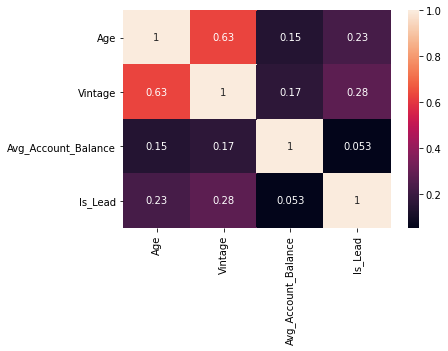

In [ ]:
corrMatrix = train_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
cat_columns = [ 'Gender', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active', "Region_Code"]
nominal_attr = {'Gender' : 2, "Occupation" : 4, "Channel_Code": 4, "Credit_Product": 3, "Is_Active" : 2}
Gender = {"Male" : 0, "Female" : 1}
Occupation  = {"Other" : 0, "Salaried" : 1, "Self_Employed" : 2, "Entrepreneur" : 3}
Channel_Code = {"X1" : 0, "X2" : 1, "X3" : 2, "X4" : 3}
Credit_Product = {"Yes" : 0, "No" : 1, "NA" : 2}
Is_Active = {"Yes" : 0, "No" : 1}
Region_Code = ['RG268', 'RG277', 'RG270', 'RG282', 'RG261', 'RG265', 'RG283',
       'RG254', 'RG269', 'RG257', 'RG279', 'RG280', 'RG252', 'RG284',
       'RG259', 'RG281', 'RG258', 'RG266', 'RG260', 'RG274', 'RG256',
       'RG275', 'RG273', 'RG267', 'RG272', 'RG251', 'RG262', 'RG264',
       'RG278', 'RG276', 'RG263', 'RG250', 'RG255', 'RG253', 'RG271']
attr_index_map = {'Gender' : Gender, "Occupation" : Occupation, "Channel_Code": Channel_Code, "Credit_Product": Credit_Product, "Is_Active" : Is_Active}

#check how many combinations have revelant number of examples. (Ignoring region code)

In [ ]:

combs = {}


for occupation in Occupation:
  for channel_code in Channel_Code:
    for credit_product in Credit_Product:
      for is_active in Is_Active:
        comb = occupation + '-' + channel_code + '-' + credit_product + '-' + is_active 
        train_temp_df = train_df.loc[(train_df['Occupation'] == occupation) & (train_df['Channel_Code'] == channel_code) & (train_df['Credit_Product'] == credit_product) & (train_df['Is_Active'] == is_active)]
        test_temp_df = test_df.loc[(test_df['Occupation'] == occupation) & (test_df['Channel_Code'] == channel_code) & (test_df['Credit_Product'] == credit_product) & (test_df['Is_Active'] == is_active) ]
        
        combs[comb] = [train_temp_df.shape[0], test_temp_df.shape[0] ]

        if (train_temp_df.shape[0] == 0) and (test_temp_df.shape[0] > 0):
          print(comb)
         

In [ ]:
import pickle

In [ ]:
with open('/content/drive/My Drive/jobathon/combs.pkl', 'wb') as file :
  pickle.dump(combs, file)


In [ ]:
with open('/content/drive/My Drive/jobathon/combs.pkl', 'rb') as file :
  combs = pickle.load(file)


In [ ]:
less_40_combs = []  # combination having less data than 40

AP = []  # combinations in which data is present for  test but absent in train

for comb in combs:
  if combs[comb][0] < 40 :
    less_40_combs.append(comb)
  if (combs[comb][0] == 0) and (combs[comb][1] > 0):
    AP.append(comb)

In [ ]:
len(AP)

0

In [ ]:
for comb in less_40_combs:
  print(combs[comb])

[36, 16]
[0, 0]
[1, 0]
[38, 9]
[29, 11]
[0, 0]
[0, 0]
[1, 0]
[0, 0]
[9, 2]
[0, 0]
[0, 0]
[10, 2]
[7, 4]


#model training

Construsting label encoders



In [ ]:
cols_to_remove = ['ID']
target = 'Is_Lead'

_X = train_df.drop(cols_to_remove + [target], axis=1)
y = train_df[target]
_XTEST = test_df.drop(cols_to_remove , axis=1)

In [ ]:
X_all = pd.concat([_X, _XTEST]).reset_index(drop=True)
X_all.shape

(351037, 9)

In [ ]:
LE = {}
for col in cat_columns:
    print(col)
    le = LabelEncoder()
    le.fit(X_all[col])
    LE[col] = le

Gender
Occupation
Channel_Code
Credit_Product
Is_Active
Region_Code


In [ ]:
LE

{'Channel_Code': LabelEncoder(),
 'Credit_Product': LabelEncoder(),
 'Gender': LabelEncoder(),
 'Is_Active': LabelEncoder(),
 'Occupation': LabelEncoder(),
 'Region_Code': LabelEncoder()}

In [ ]:
NUM_OF_BOOST_ROUND = 10000
EARLY_STOPPING = 300

In [ ]:
cat_columns_sub_data = ['Region_Code']
cols_to_remove = ['ID', 'Avg_Account_Balance'] + [x for x in cat_columns if x not in cat_columns_sub_data]
target = 'Is_Lead'

cols_to_remove

['ID',
 'Avg_Account_Balance',
 'Gender',
 'Occupation',
 'Channel_Code',
 'Credit_Product',
 'Is_Active']

In [ ]:
train_df

ID  Gender  Age  ... Avg_Account_Balance Is_Active Is_Lead
0       NNVBBKZB  Female   73  ...             1045696        No       0
1       IDD62UNG  Female   30  ...              581988        No       0
2       HD3DSEMC  Female   56  ...             1484315       Yes       0
3       BF3NC7KV    Male   34  ...              470454        No       0
4       TEASRWXV  Female   30  ...              886787        No       0
...          ...     ...  ...  ...                 ...       ...     ...
245720  BPAWWXZN    Male   51  ...             1925586        No       0
245721  HFNB7JY8    Male   27  ...              862952       Yes       0
245722  GEHAUCWT  Female   26  ...              670659        No       0
245723  GE7V8SAH  Female   28  ...              407504        No       0
245724  BOCZSWLJ    Male   29  ...             1129276        No       0

[245725 rows x 11 columns]

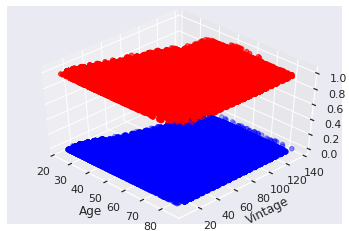

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = train_df['Age']
y = train_df['Vintage']
z = train_df['Is_Lead']

ax.set_xlabel("Age")
ax.set_ylabel("Vintage")
ax.set_zlabel("Is_Lead")

ax.scatter(x, y, z, c= z, cmap = 'bwr')
ax.view_init(45, -45)
plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
models_Knn = {}
models_catboost = {}
unique_value_combs = {}
model_name = {}


for comb in combs:
  occupation, channel_code, credit_product, is_active = comb.split('-')
  train_temp_df = train_df.loc[(train_df['Occupation'] == occupation) & (train_df['Channel_Code'] == channel_code) & (train_df['Credit_Product'] == credit_product) & (train_df['Is_Active'] == is_active)]
  if train_temp_df.shape[0] > 0:
    if len(train_temp_df[target].unique()) == 1:
      unique_value_combs[comb] = train_temp_df[target].unique()[0]
      continue
    
    X = train_temp_df.drop(cols_to_remove + [target], axis=1).reset_index(drop = True)
    Y = train_temp_df[target].reset_index(drop = True)

    # KNN
    nbr_lst = range(1, 10)
    nbr = 0
    highest_scr = 0
    for k in nbr_lst:
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(X[["Age", "Vintage"]].to_numpy(), Y.to_numpy())

      scr = knn.score(X[["Age", "Vintage"]].to_numpy(), Y.to_numpy())
      if(scr > highest_scr) :
        nbr = k
        highest_scr = scr
    
    knn = KNeighborsClassifier(n_neighbors=nbr)
  
    print(comb, combs[comb])
    knn.fit(X[["Age", "Vintage"]].to_numpy(), Y.to_numpy())

    knn_scr = roc_auc_score(Y.to_numpy(), knn.predict_proba(X[["Age", "Vintage"]].to_numpy())[:,1])
    print("knn : ", knn_scr)
    models_Knn[comb] = knn


    # corr mat
    corrMatrix = train_temp_df.corr()
    sns.heatmap(corrMatrix, annot=True)
    plt.show()

    sns.scatterplot(data = train_temp_df, x = "Age", y = "Vintage", hue = "Is_Lead")
    plt.show()
    

    # cat boost
    for cat in cat_columns_sub_data:
      X[cat] = LE[cat].transform(X[cat])

    cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns_sub_data]
    cat_features_index
    

    params = {
    'cat_features': cat_features_index,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'n_estimators': int(NUM_OF_BOOST_ROUND)
    }
    bst = CatBoostClassifier(**params, early_stopping_rounds=EARLY_STOPPING)
    _ = bst.fit(X, Y, plot=True, verbose=False)
    ypred_cat = bst.predict_proba(X)[:,1]
    models_catboost[comb] = bst
    cat_scr = roc_auc_score(Y, ypred_cat)
    print("catboost : ", cat_scr)

    if(cat_scr > knn_scr):
      model_name[comb] = "CAT"
    else:
      model_name[comb] = "KNN"


In [ ]:
import pickle
with open('/content/drive/My Drive/jobathon/unique_value_combs.pkl', 'wb') as file :
  pickle.dump(unique_value_combs, file)


In [ ]:
unique_value_combs

{'Entrepreneur-X1-No-No': 0,
 'Entrepreneur-X3-No-Yes': 0,
 'Entrepreneur-X4-NA-No': 1}

#test

In [ ]:
import pickle
with open('/content/drive/My Drive/jobathon/models.pkl', 'rb') as file :
  models = pickle.load(file)


In [ ]:

test_df['Is_Lead'] = np.nan
test_df

ID  Gender  Age  ... Avg_Account_Balance Is_Active Is_Lead
0       VBENBARO    Male   29  ...              742366        No     NaN
1       CCMEWNKY    Male   43  ...              925537        No     NaN
2       VK3KGA9M    Male   31  ...              215949        No     NaN
3       TT8RPZVC    Male   29  ...              868070        No     NaN
4       SHQZEYTZ  Female   29  ...              657087        No     NaN
...          ...     ...  ...  ...                 ...       ...     ...
105307  DBENJOYI    Male   52  ...             4242558       Yes     NaN
105308  CWQ72DWS    Male   55  ...             1159153        No     NaN
105309  HDESC8GU    Male   35  ...             1703727        No     NaN
105310  2PW4SFCA    Male   53  ...              737178       Yes     NaN
105311  F2NOYPPZ    Male   27  ...              591565        No     NaN

[105312 rows x 11 columns]

In [ ]:

for comb in combs:
  occupation, channel_code, credit_product, is_active = comb.split('-')
  test_temp_df = test_df.loc[(test_df['Occupation'] == occupation) & (test_df['Channel_Code'] == channel_code) & (test_df['Credit_Product'] == credit_product) & (test_df['Is_Active'] == is_active)]
  if test_temp_df.shape[0] > 0:
    if comb in unique_value_combs:
      indices = list(test_temp_df.index)
      for i in range(len(indices)):
        test_df[target][indices[i]] = unique_value_combs[comb]
      continue
    


    X = test_temp_df.drop(cols_to_remove + [target], axis=1)

    ypred_cat = models[comb].predict_proba(X[["Age", "Vintage"]])[:,1]
    '''
    for cat in cat_columns_sub_data:
      X[cat] = LE[cat].transform(X[cat])


    cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns_sub_data]
    cat_features_index
    

    bst = models[comb]
    ypred_cat = bst.predict_proba(X)[:,1]'''
    
    indices = list(test_temp_df.index)

    for i in range(len(indices)):
      test_df[target][indices[i]] = ypred_cat[i] 
    print(comb, combs[comb], indices)


Other-X1-Yes-Yes [722, 322] [305, 401, 622, 796, 1882, 2023, 2222, 2464, 2537, 2564, 2575, 3723, 3862, 4198, 4631, 4817, 4857, 4920, 5790, 6247, 6698, 7021, 7056, 7390, 7845, 8161, 9083, 9527, 9709, 9939, 10326, 10390, 10863, 11071, 11090, 11620, 12680, 12723, 13846, 14037, 14104, 14549, 14830, 15853, 17686, 17924, 18015, 18103, 18794, 19171, 19180, 19239, 19261, 19769, 19883, 20190, 20653, 21010, 21233, 22806, 22979, 23847, 23992, 24257, 24472, 24680, 24758, 25004, 25590, 25818, 25821, 25975, 26248, 26468, 26608, 26674, 26700, 26876, 27176, 27506, 27555, 29832, 29906, 30564, 30904, 30935, 31196, 31361, 31524, 32128, 33379, 33518, 33919, 34093, 34335, 34853, 35435, 35660, 35741, 36282, 36656, 36814, 36991, 36997, 37308, 37661, 38985, 39034, 39202, 39454, 39514, 40063, 40349, 40875, 40928, 40976, 41270, 41460, 41802, 42362, 42630, 43036, 43188, 43456, 43488, 44360, 44586, 44888, 44931, 44939, 44981, 45029, 45672, 45945, 45982, 47864, 48260, 48317, 49330, 50093, 50144, 50262, 51413, 5204

In [ ]:
test_df[target]

0         0.000000
1         0.857143
2         0.000000
3         0.000000
4         0.000000
            ...   
105307    0.857143
105308    0.428571
105309    0.000000
105310    0.142857
105311    0.000000
Name: Is_Lead, Length: 105312, dtype: float64

In [ ]:
ans = test_df[['ID', target]]
ans

ID   Is_Lead
0       VBENBARO  0.000000
1       CCMEWNKY  1.000000
2       VK3KGA9M  0.000000
3       TT8RPZVC  0.000000
4       SHQZEYTZ  0.000000
...          ...       ...
105307  DBENJOYI  1.000000
105308  CWQ72DWS  0.333333
105309  HDESC8GU  0.000000
105310  2PW4SFCA  0.166667
105311  F2NOYPPZ  0.000000

[105312 rows x 2 columns]

In [ ]:
ans.to_csv('/content/drive/My Drive/jobathon/ans.csv', index = False)

In [ ]:
data

ID  Gender  Age  ... Avg_Account_Balance Is_Active Is_Lead
0       NNVBBKZB  Female   73  ...             1045696        No       0
1       IDD62UNG  Female   30  ...              581988        No       0
2       HD3DSEMC  Female   56  ...             1484315       Yes       0
3       BF3NC7KV    Male   34  ...              470454        No       0
4       TEASRWXV  Female   30  ...              886787        No       0
...          ...     ...  ...  ...                 ...       ...     ...
245720  BPAWWXZN    Male   51  ...             1925586        No       0
245721  HFNB7JY8    Male   27  ...              862952       Yes       0
245722  GEHAUCWT  Female   26  ...              670659        No       0
245723  GE7V8SAH  Female   28  ...              407504        No       0
245724  BOCZSWLJ    Male   29  ...             1129276        No       0

[245725 rows x 11 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


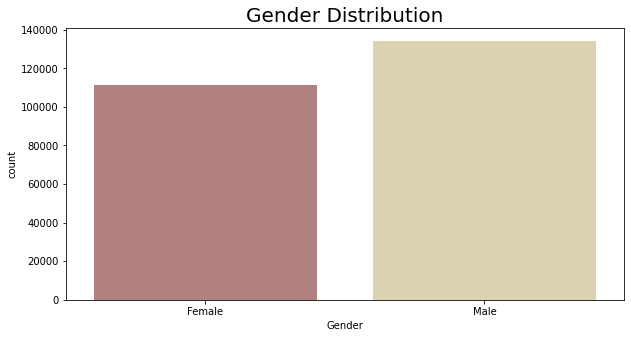

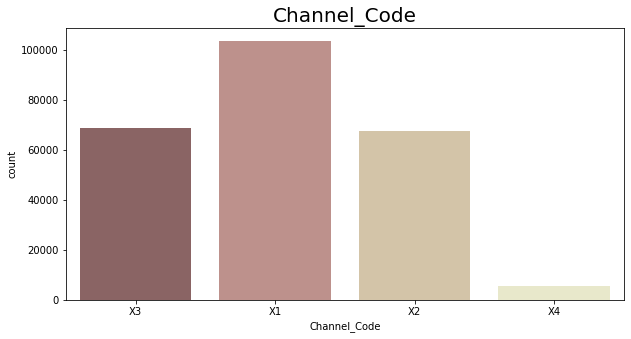

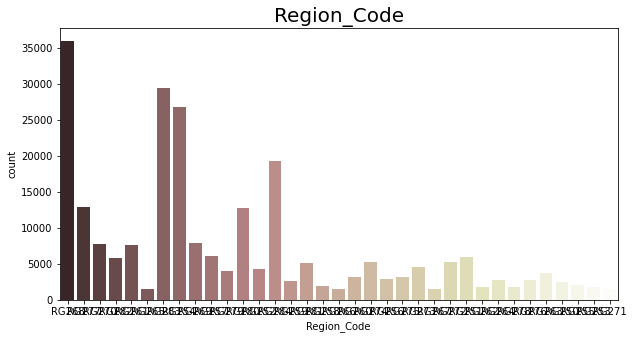

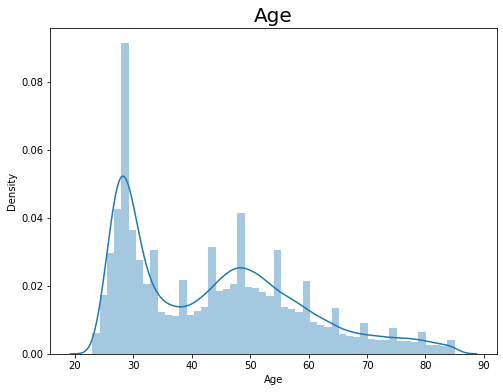

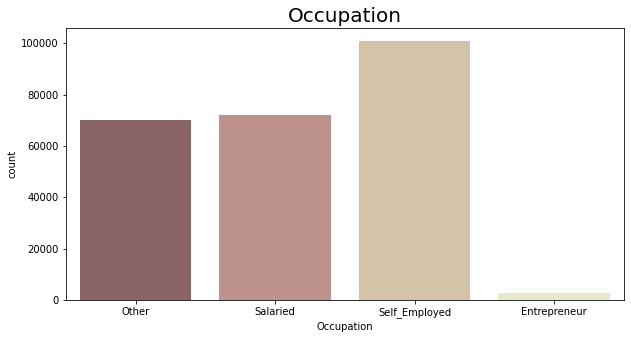

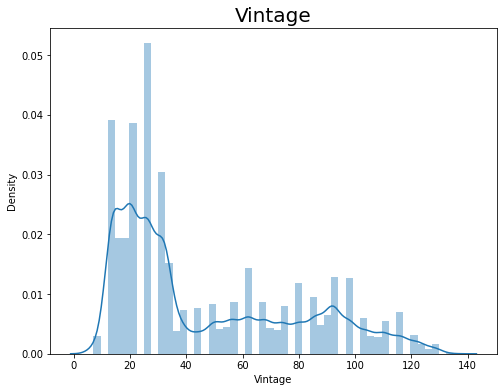

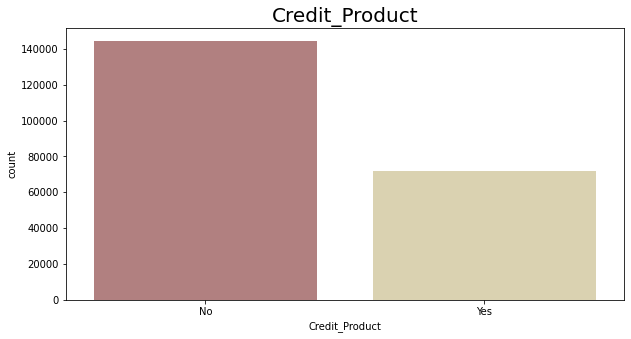

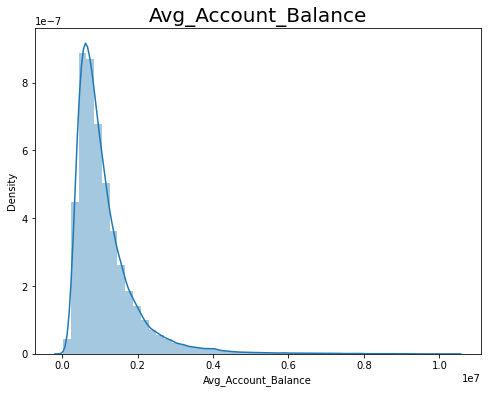

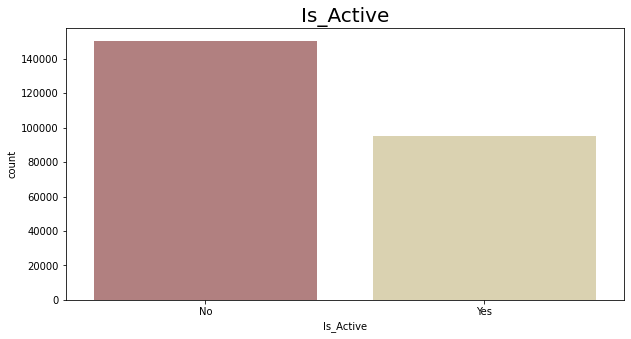

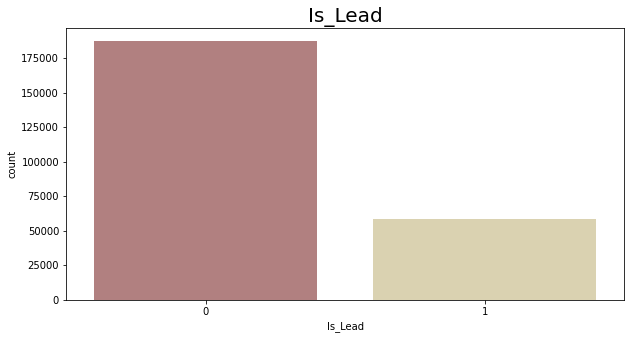

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)
sns.countplot(data['Gender'], palette = 'pink')
plt.title('Gender Distribution', fontsize = 20)
plt.show()

plt.rcParams['figure.figsize'] = (10, 5)
sns.countplot(data['Channel_Code'], palette = 'pink')
plt.title('Channel_Code', fontsize = 20)
plt.show()

plt.rcParams['figure.figsize'] = (10, 5)
sns.countplot(data['Region_Code'], palette = 'pink')
plt.title('Region_Code', fontsize = 20)
plt.show()
# Remove it, maybe not related to the output

f, ax = plt.subplots(figsize=(8,6))
x = data['Age']
ax = sns.distplot(x, bins =50)
plt.title('Age', fontsize = 20)
plt.show()
# people are buying houses at the age of 30(home loans) and at the age of 50(for their children's college and other expenses)

plt.rcParams['figure.figsize'] = (10, 5)
sns.countplot(data['Occupation'], palette = 'pink')
plt.title('Occupation', fontsize = 20)
plt.show()
# very unbalanced data wrt the entrepreneur attribute

f, ax = plt.subplots(figsize=(8,6))
x = data['Vintage']
ax = sns.distplot(x, bins =50)
plt.title('Vintage', fontsize = 20)
plt.show()

plt.rcParams['figure.figsize'] = (10, 5)
sns.countplot(data['Credit_Product'], palette = 'pink')
plt.title('Credit_Product', fontsize = 20)
plt.show()
# unbalanced towards No(Need to imputate the N/A values)

f, ax = plt.subplots(figsize=(8,6))
x = data['Avg_Account_Balance']
ax = sns.distplot(x, bins =50)
plt.title('Avg_Account_Balance', fontsize = 20)
plt.show()
# typical

plt.rcParams['figure.figsize'] = (10, 5)
sns.countplot(data['Is_Active'], palette = 'pink')
plt.title('Is_Active', fontsize = 20)
plt.show()
# unbalanced

plt.rcParams['figure.figsize'] = (10, 5)
sns.countplot(data['Is_Lead'], palette = 'pink')
plt.title('Is_Lead', fontsize = 20)
plt.show()
# Unbalanced dataset


# leaving region code for now(Imputation)


In [ ]:
data["Credit_Product"] = data["Credit_Product"].fillna("NA")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       245725 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


## Input data creation

Normalise numeric data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       245725 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [ ]:
mean_age = data["Age"].mean()
std_age = data["Age"].std()

mean_vintage = data["Vintage"].mean()
std_vintage = data["Vintage"].std()

mean_accbal = data["Avg_Account_Balance"].mean()
std_accbal = data["Avg_Account_Balance"].std()


In [ ]:
data['Age'] = data['Age'].apply(lambda x : (x-mean_age)/std_age)
data['Vintage'] = data['Vintage'].apply(lambda x : (x-mean_vintage)/std_vintage)
data['Avg_Account_Balance'] = data['Avg_Account_Balance'].apply(lambda x : (x-mean_accbal)/std_accbal)

In [ ]:
def input_data(x):
  ans = []
  for attr in nominal_attr:
    n = len(ans)
    ans = ans+[0]*nominal_attr[attr]
    ans[n+ attr_index_map[attr][x[attr]]] = 1
  ans = ans + [ x['Age'], x['Vintage'], x['Avg_Account_Balance']]  
  return ans

In [ ]:
# [nominal attr, numerical attr]
nominal_attr = {'Gender' : 2, "Occupation" : 4, "Channel_Code": 4, "Credit_Product": 3, "Is_Active" : 2}
Gender = {"Male" : 0, "Female" : 1}
Occupation  = {"Other" : 0, "Salaried" : 1, "Self_Employed" : 2, "Entrepreneur" : 3}
Channel_Code = {"X1" : 0, "X2" : 1, "X3" : 2, "X4" : 3}
Credit_Product = {"Yes" : 0, "No" : 1, "NA" : 2}
Is_Active = {"Yes" : 0, "No" : 1}
attr_index_map = {'Gender' : Gender, "Occupation" : Occupation, "Channel_Code": Channel_Code, "Credit_Product": Credit_Product, "Is_Active" : Is_Active}

for attr in nominal_attr:
  data[attr] = data[attr].astype('str')

input = list(data.apply(input_data, axis=1).to_numpy())

In [ ]:
input = np.array(input)

In [ ]:
input.shape

(245725, 18)

In [ ]:
output = data["Is_Lead"].to_numpy()

In [ ]:
output.shape

(245725,)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
from keras import backend as K


def model():
  inp = keras.layers.Input(shape = (18))
  out = tf.keras.layers.Dense(50, activation = 'relu')(inp)
  out = tf.keras.layers.Dense(40, activation = 'relu')(out)
  out = tf.keras.layers.Dense(30, activation = 'relu')(out)
  out = tf.keras.layers.Dense(20, activation = 'relu')(out)
  out = tf.keras.layers.Dense(15, activation = 'relu')(out)
  out = tf.keras.layers.Dense(10, activation = 'relu')(out)
  out = tf.keras.layers.Dense(1, 'sigmoid')(out)
  mod = tf.keras.Model(inp, out)
  return mod

In [ ]:
mod = model()
mod.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                950       
_________________________________________________________________
dense_6 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_9 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                160 

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = 'binary_crossentropy'
mod.compile(optimizer=optimiser, loss=loss, metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)])

In [ ]:
mod.fit(
    x=input, y=output, batch_size=input.shape[0], epochs=10000, verbose=1,
    validation_split=0.1, shuffle=True, validation_freq=5
)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 66ms/step - loss: 0.3257 - accuracy: 0.8680 - auc_1: 0.8857
Epoch 5048/10000
1/1 [==============================] - 0s 55ms/step - loss: 0.3268 - accuracy: 0.8674 - auc_1: 0.8850
Epoch 5049/10000
1/1 [==============================] - 0s 57ms/step - loss: 0.3291 - accuracy: 0.8664 - auc_1: 0.8835
Epoch 5050/10000
1/1 [==============================] - 0s 92ms/step - loss: 0.3267 - accuracy: 0.8676 - auc_1: 0.8852 - val_loss: 0.3933 - val_accuracy: 0.8538 - val_auc_1: 0.8616
Epoch 5051/10000
1/1 [==============================] - 0s 73ms/step - loss: 0.3264 - accuracy: 0.8680 - auc_1: 0.8856
Epoch 5052/10000
1/1 [==============================] - 0s 57ms/step - loss: 0.3277 - accuracy: 0.8674 - auc_1: 0.8843
Epoch 5053/10000
1/1 [==============================] - 0s 62ms/step - loss: 0.3270 - accuracy: 0.8675 - auc_1: 0.8849
Epoch 5054/10000
1/1 [==============================] - 0s 63ms/step - 

KeyboardInterrupt: ignored

# Test


In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/jobathon/test.csv')


In [ ]:
test_data["Credit_Product"] = test_data["Credit_Product"].fillna("NA")
test_data['Age'] = test_data['Age'].apply(lambda x : (x-mean_age)/std_age)
test_data['Vintage'] = test_data['Vintage'].apply(lambda x : (x-mean_vintage)/std_vintage)
test_data['Avg_Account_Balance'] = test_data['Avg_Account_Balance'].apply(lambda x : (x-mean_accbal)/std_accbal)

In [ ]:
test_data

ID  Gender  ...  Avg_Account_Balance Is_Active
0       VBENBARO    Male  ...            -0.452598        No
1       CCMEWNKY    Male  ...            -0.237844        No
2       VK3KGA9M    Male  ...            -1.069780        No
3       TT8RPZVC    Male  ...            -0.305220        No
4       SHQZEYTZ  Female  ...            -0.552581        No
...          ...     ...  ...                  ...       ...
105307  DBENJOYI    Male  ...             3.651099       Yes
105308  CWQ72DWS    Male  ...             0.036052        No
105309  HDESC8GU    Male  ...             0.674521        No
105310  2PW4SFCA    Male  ...            -0.458680       Yes
105311  F2NOYPPZ    Male  ...            -0.629400        No

[105312 rows x 10 columns]

In [ ]:
for attr in nominal_attr:
  data[attr] = data[attr].astype('str')

test_input = list(test_data.apply(input_data, axis=1).to_numpy())

In [ ]:
test_input = np.array(test_input)


In [ ]:
test_input.shape

(105312, 18)

In [ ]:
predicted = mod(test_input)

In [ ]:
predicted

<tf.Tensor: shape=(105312, 1), dtype=float32, numpy=
array([[4.0238541e-02],
       [9.8846406e-01],
       [5.2084029e-02],
       ...,
       [4.3253449e-13],
       [1.8440814e-01],
       [4.7093354e-02]], dtype=float32)>

In [ ]:
ans = np.append(np.expand_dims(test_data['ID'].to_numpy(), axis = 1) , np.expand_dims(predicted[:, 0], axis = 1), axis = 1)

In [ ]:
ans

array([['VBENBARO', 0.04023854061961174],
       ['CCMEWNKY', 0.9884640574455261],
       ['VK3KGA9M', 0.05208402872085571],
       ...,
       ['HDESC8GU', 4.3253448782712423e-13],
       ['2PW4SFCA', 0.18440814316272736],
       ['F2NOYPPZ', 0.04709335416555405]], dtype=object)

In [ ]:
ans = pd.DataFrame(ans, columns = ['ID','Is_Lead'])

In [ ]:
ans

ID      Is_Lead
0       VBENBARO    0.0402385
1       CCMEWNKY     0.988464
2       VK3KGA9M     0.052084
3       TT8RPZVC    0.0146139
4       SHQZEYTZ     0.013783
...          ...          ...
105307  DBENJOYI            1
105308  CWQ72DWS     0.598202
105309  HDESC8GU  4.32534e-13
105310  2PW4SFCA     0.184408
105311  F2NOYPPZ    0.0470934

[105312 rows x 2 columns]

In [ ]:
ans.to_csv('/content/drive/My Drive/jobathon/ans.csv', index = False)